In [487]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show/hide code."></form>''')

-----

<h1 align="center"> Model Analysis </h1><br>
This notebook explores the provided crop and livestock predicts from FAOSTAT. Scatterplots were generated comparing disease mortality rates per 100,000 and food item consumption in kg/capita/year. This analysis was extended for cancer, diabetes, and cardiovascular disease and over 100 predictors were examined. The top positively and negatively correlated predictors are printed below.

-----

In [558]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import pandas as pd
import math
from IPython.display import Image
from IPython.core.display import HTML 
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score as val_score
from sklearn.linear_model import LinearRegression as LinReg
import missingno as msno
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split as sk_split
import statsmodels.api as sm
import pycountry
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs

%matplotlib inline

Data for crop and livestock predictors are read in from the original sources.

In [559]:
allcrops_2000 = pd.read_csv('datasets/allcrops_2000.csv')
# names of all the crops
crop_names = allcrops_2000['Item'].unique()

# remove nan
crop_names = crop_names[:-1]
# list to put our separated crop dataframes
all_crop_dfs = []

# find each crop-separated df and put it in the list of dataframes
for crop in crop_names:
    crop_df = allcrops_2000[(allcrops_2000['Item'] == crop)]
    all_crop_dfs.append(crop_df)

In [560]:
# Do the same as above, but for livestock
livestock_2000 = pd.read_csv('datasets/livestock_2000.csv')
# list of livestock names
livestock_names = livestock_2000['Item'].unique()
livestock_names = livestock_names[:-1]

# list to put our separated dataframes
livestock_dfs = []

# separate dataframe based on itemname
for crop in livestock_names:
    crop_df = livestock_2000[(livestock_2000['Item'] == crop)]
    livestock_dfs.append(crop_df)

The following cells read in both the actual and predicted mortality rates. Actual disease mortality rates were obtained from the WHO database online. Predicted mortality rates stem from best results of the advanced model chapter. For cancer and diabetes, this was a combination of linear regression and ridge selection for variable selection. For cardiovascular disease, this consisted of linear regression and LASSO variable selection. 

In [561]:
# read in predicted disease rates
country_names = pd.read_csv('datasets/country_names_156.csv')
diabetes_predict = pd.read_csv('datasets/diabetes_predict_1.txt')
cardio_predict = pd.read_csv('datasets/cardio_predict_1.txt')
cancer_predict = pd.read_csv('datasets/Cancer_predict_1.txt')

In [562]:
# read in actual disease rates
column_headers = ["Country", "Year", "Mortality", "Mortality 2", "Mortality 3"]
diabetes_actual = pd.read_csv('datasets/Diabetes_WHO.csv', names = column_headers)
cardio_actual = pd.read_csv('datasets/cardio_WHO.csv', names = column_headers)
cancer_actual = pd.read_csv('datasets/Cancer_WHO.csv', names = column_headers)
all_foods = all_crop_dfs

In [563]:
# separate out 2012 and 2000 data
cardio_2012 = cardio_actual[(cardio_actual["Year"] == "2012")] 
cardio_2000 = cardio_actual[(cardio_actual["Year"] == "2000")] 
diabetes_2012 = diabetes_actual[(diabetes_actual['Year'] == '2012')] 
diabetes_2000 = diabetes_actual[(diabetes_actual['Year'] == '2000')] 
cancer_2012 = cancer_actual[(cancer_actual['Year'] == ' 2012')] 
cancer_2000 = cancer_actual[(cancer_actual['Year'] == ' 2000')] 

# Actual and Predicted Mortality Rates World Map

The predicted values were all concatenated into a dataset for convenience in conducting the analysis. The first step of cleaning the data was to transform country names to the international standard. Cartopy, our package for plotting world maps, relies on country 3 letter standard codes. Thus, the country names first must be standardized and then run through py.country to change to their corresponding codes (ex. the code for China is CHN). 

In [567]:
full_dataset = np.column_stack([country_names, cancer, diabetes, cardio])
full_dataset = np.sort(full_dataset, axis=0, kind='quicksort', order=None)
country_names = full_dataset[:,0]

Here we wrote a function to change the appropriate country names to match those that Cartopy recognizes, and ran it on the list of country names in our predictor dataset.

In [568]:
def change_names(country_names):
    input_countries = country_names
    counter = 1
    for each in range(1, len(input_countries)):
        if input_countries[counter] == 'Bolivia (Plurinational State of)':
            input_countries[counter] = 'Bolivia, Plurinational State of'
        if input_countries[counter] == 'Iran (Islamic Republic of)':
            input_countries[counter] = 'Iran, Islamic Republic of'
        if input_countries[counter] == "C\xc3\xb4te d'Ivoire":
            input_countries[counter] = 'Cote d\'Ivoire'
        if input_countries[counter] == 'China, Macao SAR':
            input_countries[counter] = 'Macao'
        if input_countries[counter] == "Democratic People's Republic of Korea":
            input_countries[counter] = 'Korea, Democratic People\'s Republic of'
        if input_countries[counter] == 'Republic of Korea':
            input_countries[counter] = 'Korea, Republic of'
        if input_countries[counter] == 'The former Yugoslav Republic of Macedonia':
            input_countries[counter] = 'Macedonia, Republic of'
        if input_countries[counter] == 'Sudan (former)':
            input_countries[counter] = 'Sudan'
        if input_countries[counter] == 'Venezuela (Bolivarian Republic of)':
            input_countries[counter] = 'Venezuela, Bolivarian Republic of'
        if input_countries[counter] == 'United States of America':
            input_countries[counter] = 'United States'
        if input_countries[counter] == 'China, Taiwan Province of':
            input_countries[counter] = 'Taiwan, Province of China'
        if input_countries[counter] == 'China, mainland':
            input_countries[counter] = 'China'
        if input_countries[counter] == 'China, Hong Kong SAR':
            input_countries[counter] = 'Hong Kong'
        if input_countries[counter] == 'Republic of Moldova':
            input_countries[counter] = 'Moldova, Republic of'
        if input_countries[counter] == 'United Republic of Tanzania':
            input_countries[counter] = 'Tanzania, United Republic of'
        if input_countries[counter] == 'Czechia':
            input_countries[counter] = 'Czechoslovakia'
        if input_countries[counter] == 'Netherlands Antilles':
            input_countries[counter] = 'Netherlands'
        if input_countries[counter] == 'Cabo Verde':
            input_countries[counter] = 'Cabo Verde, Republic of'
        counter = counter + 1

In [569]:
change_names(country_names)

We create an dictionary for quick lookup, and then iterate through the names in our dataset and change them into Cartopy-friendly country codes.

In [570]:
# create array of countries to convert country name to 3 letter Alpha code
countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha3

# iterate through all countries and compile list of codes, return unknown if no code is present
codes = [countries.get(country, country) for country in country_names]

The below two functions do the bulk of the mapping as we transform our data into a world map. Regarding the predicted values, the first function, we begin by removing all predicted values that may stem from outliers. These values are replaced by 0 since we cannot have any negative figures of disease mortality rate. The next step is to normalize the ranges by finding the maximum value and dividing each mortality rate by that figure to end up with a value between 0 and 1. Next, we plot these normalized values using a function called facecolor, which uses proportions to indicate how pigmented each CMYK filter should be to properly color the map. By normalizing disease mortality, we can compare rates across different countries by noting how dark the shade of blue is. Greenland was manually added in to be the same code as Iceland because they are treating separately in Cartopy but were grouped together in the WHO database. This same analysis of normalizing values was applied to the actual disease mortality rates dataset. The legend shows you the incidence rate per 100,000 individuals so you can compare absolute quantities in addition to relative amounts from the color gradation. 

In [500]:
def world_map(disease, dataset, number, max_value):
    # score disease data as floats
    disease_rates = dataset[:,number]
    float_disease_array = []
    for index, value in enumerate(disease_rates):
        if value < 0: 
            disease_rates[index] = 0
            float_disease_array.append(0)
        else:
            float_disease_array.append(float(value))
            
    # find maximum value for normalization
#     max_value = np.max(float_disease_array) + 1
    
    # plot cartopy world map projection
    # ax = plt.axes(projection=ccrs.PlateCarree())
    fig, ax = plt.subplots(figsize=(12,6), 
                           subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-150, 60, -25, 60])

    # initialize the type of projdction and map outline format
    shpfilename = shpreader.natural_earth(resolution='110m',
                                          category='cultural',
                                          name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    countries = reader.records()

    # initialize counter variable k 
    k = 0
    for country in countries:

        # for each country with a country code, color the country in proportion to the cardiovascular mortality rate
        if any(country.attributes['adm0_a3'] in j for (k,j) in enumerate(codes)):
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                              facecolor=[0, 1-(float(dataset[k,number])/max_value), 1],
                              label=country.attributes['adm0_a3'])
            k = k + 1

        # color Greenland the same as Iceland
        elif country.attributes['adm0_a3'] == 'GRL':
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                              facecolor=[0, 1-(float(dataset[k,number])/max_value), 1],
                              label=country.attributes['adm0_a3'])

        # for all countries with no cardiovascular mortality data, make the country gray
        else:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                              facecolor = [0.8, 0.8, 0.8],
                              label=country.attributes['adm0_a3'])
        ax.set_title('Predicted ' + str(disease) + ' Disease Mortality Rate by Country')

        cmap = plt.cm.Blues
        cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
        norm = mpl.colors.Normalize(vmin=0, vmax=max_value)
        cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional')
        cb.set_label(str(disease) + ' Mortality per Capita')

    plt.show()

In [501]:
def world_map_actual(disease_rates, disease, dataset):
    float_disease_array = []
    for each in disease_rates:
        float_disease_array.append(float(each))
    max_value = np.max(float_disease_array) + 1
    
    # plot cartopy world map projection
    # ax = plt.axes(projection=ccrs.PlateCarree())
    fig, ax = plt.subplots(figsize=(12,6), 
                           subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-150, 60, -25, 60])

    # initialize the type of projdction and map outline format
    shpfilename = shpreader.natural_earth(resolution='110m',
                                          category='cultural',
                                          name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    countries = reader.records()

    # initialize counter variable k 
    k = 0
    for country in countries:

        # for each country with a country code, color the country in proportion to the cardiovascular mortality rate
        if any(country.attributes['adm0_a3'] in j for (k,j) in enumerate(codes)):
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                              facecolor=[0, 1-(float(dataset[k,1])/max_value), 1],
                              label=country.attributes['adm0_a3'])
            k = k + 1

        # since USA has a unique format, append the USA's separate mortality index
        elif country.attributes['adm0_a3'] == 'GRL':
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                              facecolor=[0, 1-(float(dataset[k,1])/max_value), 1],
                              label=country.attributes['adm0_a3'])

        # for all countries with no cardiovascular mortality data, leave the country blank
        else:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                              facecolor = [0.8, 0.8, 0.8],
                              label=country.attributes['adm0_a3'])
        ax.set_title('Actual ' + str(disease) + ' Disease Mortality Rate by Country')

        cmap = plt.cm.Blues
        cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
        norm = mpl.colors.Normalize(vmin=0, vmax=max_value)
        cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional')
        cb.set_label(str(disease) + ' Mortality per Capita')

    plt.show()
    return max_value

We format the disease mortality rates into matrices for better use with cartopy, and run the names of the country list that are both the disease and input dataframes through our function to change them into Cartopy-friendly names.

In [502]:
cancer_2000[["Country", "Mortality"]]
cancer_rates = cancer_2000["Mortality"].as_matrix()
country_list_actual = cancer_2000["Country"].as_matrix()
change_names(country_list_actual)
cancer_full = np.column_stack((country_list_actual, cancer_rates))

After that, we're able to generate a world map with different shades of blue based on real and predicted cancer data rates. Here, darker colors indicate higher mortality rates and lighter colors indicate lower mortality rates. The top map shows the actual cancer mortality rates, and the bottom map shows our predicted cancer mortality rates.

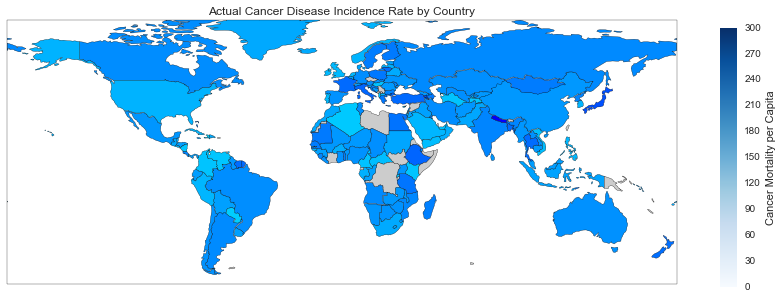

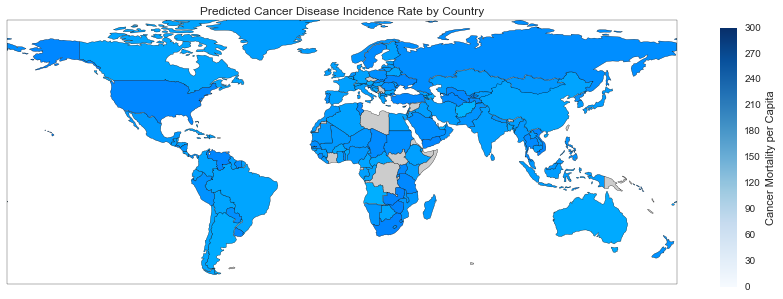

In [503]:
max_value = world_map_actual(cancer_rates, "Cancer", cancer_full)
world_map("Cancer", full_dataset, 1, max_value)

Visually, we can see that both the predicted and actual maps have similar colorings, indicating that our model is doing pretty well. From the legend, we can see that our predicted and actual cancer ranges are within the same range, which is a strong first indication of the validity of our model. However, there is noticeable variability, for example for United States, we are overpredicting cancer mortality rates while in China, we are underpredicting the mortality rate.

In [504]:
diabetes_2000[["Country", "Mortality"]]
diabetes_rates = diabetes_2000["Mortality"].as_matrix()
country_list_actual = diabetes_2000["Country"].as_matrix()
change_names(country_list_actual)
diabetes_full = np.column_stack((country_list_actual, diabetes_rates))

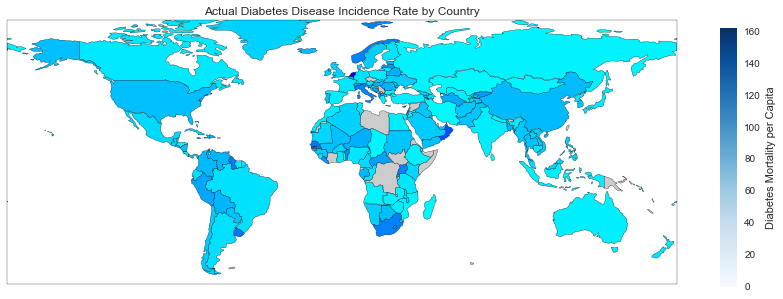

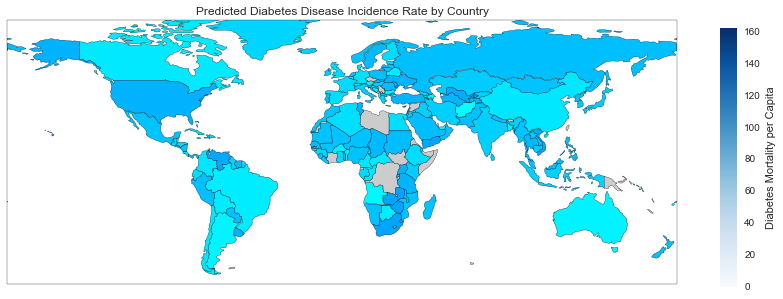

In [505]:
max_value = world_map_actual(diabetes_rates, "Diabetes", diabetes_full)
world_map("Diabetes", full_dataset, 2, max_value)

In [506]:
cardio_2000[["Country", "Mortality"]]
cardio_rates = cardio_2000["Mortality"].as_matrix()
country_list_actual = cardio_2000["Country"].as_matrix()
change_names(country_list_actual)
cardio_full = np.column_stack((country_list_actual, cardio_rates))

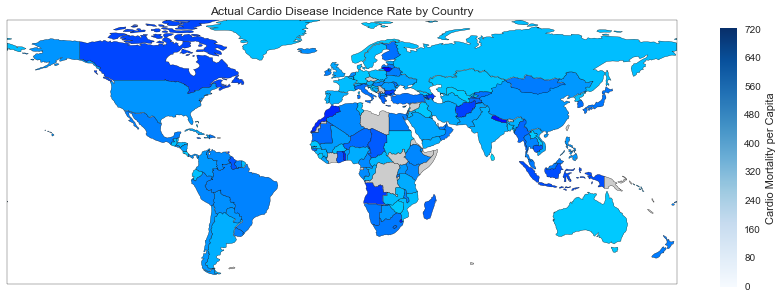

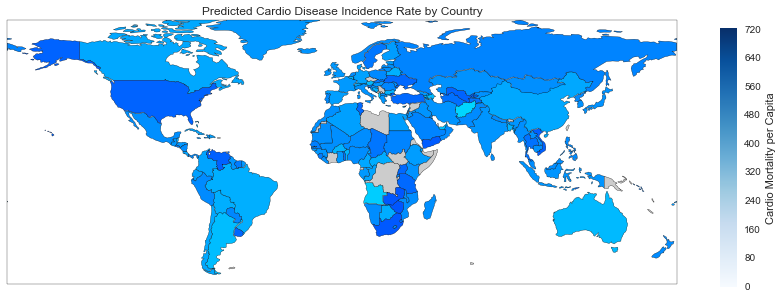

In [507]:
max_value = world_map_actual(cardio_rates, "Cardio", cardio_full)
world_map("Cardio", full_dataset, 3, max_value)

# Predictor Impact Analysis

In order to get a better idea how each individual predictor affects disease mortality rate, we created bubble charts for each disease. Each bubble corresponds to a specific predictor. The area of the bubble is proportional to the size of the coefficient of the predictorin the model. Red bubbles indicate a positive coefficient, meaning that the corresponding predictor causes an increase in disease mortality rate and thus is not recommended in a person's diet, while blue bubbles indicate a negative coefficient, or a predictor that will lower the disease mortality rate.

## Cancer

d3 Code for visualizing the impact of cancer predictors, written in JavaScript:

In [11]:
<style>
text {
  font: 20px "Helvetica Neue", Helvetica, Arial, sans-serif;
  text-anchor: middle;
}
</style>
<svg width="960" height="1000"></svg>
<script src="https://d3js.org/d3.v4.min.js"></script>
<script>
var svg = d3.select("svg"),
    width = +svg.attr("width");
var format = d3.format(",d");
var color = d3.scaleOrdinal(d3.schemeCategory20c);
var pack = d3.pack()
    .size([width, width])
    .padding(1.5);
d3.csv("cancer.csv", function(d) {
  d.value = +d.value;
  if (d.value) return d;
}, function(error, classes) {
  if (error) throw error;
  var root = d3.hierarchy({children: classes})
      .sum(function(d) { return d.value; })
      .each(function(d) {
        if (id = d.data.id) {
          var id, i = id.lastIndexOf(".");
          d.id = id;
          d.package = id.slice(0, i);
          d.class = id.slice(i + 1);
        }
      });
  var node = svg.selectAll(".node")
    .data(pack(root).leaves())
    .enter().append("g")
      .attr("class", "node")
      .attr("transform", function(d) { return "translate(" + d.x + "," + d.y + ")"; });
  node.append("circle")
      .attr("id", function(d) { return d.id; })
      .attr("r", function(d) { return d.r; })
      .style("fill", function(d) { 
        if (d.package == "positive") {
          return "rgb(220,20,60)"; // red
        }
        else {
          return "rgb(100, 163, 209)"; //blue
        }});
  node.append("clipPath")
      .attr("id", function(d) { return "clip-" + d.id; })
    .append("use")
      .attr("xlink:href", function(d) { return "#" + d.id; });
  node.append("text")
    .style("font-size", function(d) {return Math.min(.4* d.r, (2 * d.r - 8) / this.getComputedTextLength()) + "px"; })
      .attr("clip-path", function(d) { return "url(#clip-" + d.id + ")"; })
    .selectAll("tspan")
    .data(function(d) { return d.class.split(/(?=[A-Z][^A-Z])/g); })
    .enter().append("tspan")
      .attr("x", 0)
      .attr("y", function(d, i, nodes) {
       return 20 + (i - nodes.length / 2 - 0.5) * 20; })
      .text(function(d) {
          return d; });
  node.append("title")
      .text(function(d) { return d.id + "\n" + format(d.value); });
});
</script>

SyntaxError: invalid syntax (<ipython-input-11-18f3a902d8e9>, line 1)

In [508]:
print 'Impact of Food Predictors on Cancer:'
Image(url= "http://i.imgur.com/AplbAx9.png", width=300)

Impact of Food Predictors on Cancer:


### Coefficient Analysis - Cancer:

This bubble chart was generated using the coefficients from the improved model for the cancer. We should be careful to preface this discussion with a reminder that the improved model was only able to achieve a cross-validated $r^2$ of .200 for 7-fold validation, and a score of .782 on the original dataset. As such, these results and any associations of certain foods with cancer should be considered with this in mind. 

That said, examining this buble chart we notice that fish liver oil appears to have a negative correlation with cancer mortality rates, offering some support for conventional wisdom that fish oil is a good supplement to take. We see positive associations with cancer mortality rates with pepper, cloves, and aquatic animals, which might seem contradictory. This is likely because diet is just not very strongly correlated with cancer, which is why we might be seeing some of these seemingly contradictory results.


d3 Code for visualizing the impact of diabetes predictors, written in JavaScript:

In [ ]:
<!DOCTYPE html>
<meta charset="utf-8">
<style>
text {
  font: 20px "Helvetica Neue", Helvetica, Arial, sans-serif;
  text-anchor: middle;
}
</style>
<svg width="960" height="1000"></svg>
<script src="https://d3js.org/d3.v4.min.js"></script>
<script>
var svg = d3.select("svg"),
    width = +svg.attr("width");
var format = d3.format(",d");
var color = d3.scaleOrdinal(d3.schemeCategory20c);
var pack = d3.pack()
    .size([width, width])
    .padding(1.5);
d3.csv("diabetes.csv", function(d) {
  d.value = +d.value;
  if (d.value) return d;
}, function(error, classes) {
  if (error) throw error;
  var root = d3.hierarchy({children: classes})
      .sum(function(d) { return d.value; })
      .each(function(d) {
        if (id = d.data.id) {
          var id, i = id.lastIndexOf(".");
          d.id = id;
          d.package = id.slice(0, i);
          d.class = id.slice(i + 1);
        }
      });
  var node = svg.selectAll(".node")
    .data(pack(root).leaves())
    .enter().append("g")
      .attr("class", "node")
      .attr("transform", function(d) { return "translate(" + d.x + "," + d.y + ")"; });
  node.append("circle")
      .attr("id", function(d) { return d.id; })
      .attr("r", function(d) { return d.r; })
      .style("fill", function(d) { 
        if (d.package == "positive") {
          return "rgb(220,20,60)"; // red
        }
        else {
          return "rgb(100, 163, 209)" //blue
        }});
  node.append("clipPath")
      .attr("id", function(d) { return "clip-" + d.id; })
    .append("use")
      .attr("xlink:href", function(d) { return "#" + d.id; });
  node.append("text")
    .style("font-size", function(d) {return Math.min(.4* d.r, (2 * d.r - 8) / this.getComputedTextLength()) + "px"; })
      .attr("clip-path", function(d) { return "url(#clip-" + d.id + ")"; })
    .selectAll("tspan")
    .data(function(d) { return d.class.split(/(?=[A-Z][^A-Z])/g); })
    .enter().append("tspan")
      .attr("x", 0)
      .attr("y", function(d, i, nodes) {
        if (d == "Fish, ")
          return -50;
        else if (d == "Oil" & nodes.length == 3)
          return 60;
        else
       return 20 + (i - nodes.length / 2) * 30; })
      .text(function(d) {
        if (d == "Meat, "|| d == "Mammals" || d== "Meat " || d == "Meal" || d == "Milk, "|| d == "Whole"|| d== "Sugar cane")
          return "";
        else if (d== "Beverages (" || d== "Fermented)")
          return "";
        else 
          return d; });
  node.append("title")
      .text(function(d) { return d.id + "\n" + format(d.value); });
});
</script>

In [509]:
print 'Impact of Food Predictors on Diabetes:'
Image(url= "http://i.imgur.com/tRwjjdu.png", width=300)

Impact of Food Predictors on Diabetes:


d3 Code for visualizing the impact of cardiovascular disease predictors, written in JavaScript:

In [ ]:
<!DOCTYPE html>
<meta charset="utf-8">
<style>
text {
  font: 30px "Helvetica Neue", Helvetica, Arial, sans-serif;
  text-anchor: middle;
}
</style>
<svg width="960" height="1000"></svg>
<script src="https://d3js.org/d3.v4.min.js"></script>
<script>
var svg = d3.select("svg"),
    width = +svg.attr("width");
var format = d3.format(",d");
var color = d3.scaleOrdinal(d3.schemeCategory20c);
var pack = d3.pack()
    .size([width, width])
    .padding(1.5);
d3.csv("cardio.csv", function(d) {
  d.value = +d.value;
  if (d.value) return d;
}, function(error, classes) {
  if (error) throw error;
  var root = d3.hierarchy({children: classes})
      .sum(function(d) { return d.value; })
      .each(function(d) {
        if (id = d.data.id) {
          var id, i = id.lastIndexOf(".");
          d.id = id;
          d.package = id.slice(0, i);
          d.class = id.slice(i + 1);
        }
      });
  var node = svg.selectAll(".node")
    .data(pack(root).leaves())
    .enter().append("g")
      .attr("class", "node")
      .attr("transform", function(d) { return "translate(" + d.x + "," + d.y + ")"; });
  node.append("circle")
      .attr("id", function(d) { return d.id; })
      .attr("r", function(d) { return d.r; })
      .style("fill", function(d) { 
        if (d.package == "positive") {
          return "rgb(220,20,60)"; // red
        }
        else {
          return "rgb(100, 163, 209)" ; //blue
        }});
  node.append("clipPath")
      .attr("id", function(d) { return "clip-" + d.id; })
    .append("use")
      .attr("xlink:href", function(d) { return "#" + d.id; });
  node.append("text")
    .style("font-size", function(d) {return Math.min(.4* d.r, (2 * d.r - 8) / this.getComputedTextLength()) + "px"; })
      .attr("clip-path", function(d) { return "url(#clip-" + d.id + ")"; })
    .selectAll("tspan")
    .data(function(d) { return d.class.split(/(?=[A-Z][^A-Z])/g); })
    .enter().append("tspan")
      .attr("x", 0)
      .attr("y", function(d, i, nodes) {
        if (d == "Fish, ")
          return -50;
        else if (d == "Oil" & nodes.length ==3)
          return 60;
        else
       return 20 + (i - nodes.length / 2) * 30; })
      .text(function(d) {
        if (d == "Meat, " || d =="Aquatic " || d == "Mammals" || d== "Meat " || d == "Meal" || d == "Milk, "|| d == "Whole"||d=="Sweet potatoes" || d== "Pelagic "||d == "Fish")
          return "";
        else if (d== "Beverages (" || d== "Fermented)")
          return "";
        else 
          return d; });
  node.append("title")
      .text(function(d) { return d.id + "\n" + format(d.value); });
});
</script>

In [510]:
print 'Impact of Food Predictors on Cardiovascular Disease:'
Image(url= "http://i.imgur.com/tLT2F69.png", width=300)

Impact of Food Predictors on Cardiovascular Disease:


Using our improved model for cardio, we see that after running lasso we've kept the top 15 predictors of cardiovascular diseases. According to our model, molluscs, coffee, soybean oil, olive oil, oranges, cephalopods, and bananas are some of the "healthiest" foods with respect to cardiovascular diseases. On the other hand, rye, wheat, cottenseed oil, mutton, and sugar are positively correlated with cardiovascular diseases.

# World Error Maps

Although we do have the R^2 metric, R^2 does not tell us anything about how our model performs for specific countries. In order to visualize that, we calculated the fractional difference between our predicted disease mortality rate and the true disease mortality for that country. We then colored each country on a map according to that fractional difference on a gradient.

Here we sort the predicted data frame by countries.

In [575]:
predicted_df = pd.DataFrame({'country':country_list, 'cardio': predicted_cardio, 'cancer': predicted_cancer, 'diabetes': predicted_diabetes})
predicted_df = predicted_df.sort_values('country')

## Calculating Error

Below we calculate the fractional differences according to the formula $$\frac{\text{predicted value} - \text{true value}}{\text{true value}}$$

In [579]:
diff_cancer = []
diff_diabetes = []
diff_cardio = []
for index, cancer_val, cardio_val, country, diabetes_val in predicted_df.itertuples():
    real_cancer = cancer_2000[cancer_2000['Country'] == country]['Mortality']
    diff_cancer.append((cancer_val - float(real_cancer))/float(real_cancer) )
    real_cardio = cardio_2000[cardio_2000['Country'] == country]['Mortality']
    diff_cardio.append((cardio_val - float(real_cardio))/float(real_cardio))
    real_diabetes = diabetes_2000[diabetes_2000['Country'] == country]['Mortality']
    if abs((diabetes_val - float(real_diabetes))/float(real_diabetes)) > 1:
        diff_diabetes.append(0)
    else:
        diff_diabetes.append((diabetes_val - float(real_diabetes))/float(real_diabetes))


We generate the three letter codes for each country so that Cartopy will recognize them.

In [580]:
# create array of countries to convert country name to 3 letter Alpha code
countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha3

# iterate through all countries and compile list of codes, return unknown if no code is present
codes = [countries.get(country, country) for country in diff_matrix[:,0]]

Here we find the maximum and minimum fractional differences to help us determine the color gradient to shade the countries.

In [590]:
cancer_rates = diff_matrix[:,1]
float_cancer_array = []
for each in cancer_rates:
    float_cancer_array.append(float(each))
max_value = np.max(float_cancer_array) 
min_value = np.min(float_cancer_array) 

## Analysis for the Cancer Error Map

The code below creates the world map with the appropriate shading for each country. For every country that we do not have data for, we shade it gray. As we can see from the scale on the right, dark blue and dark purple represent fractional errors that are close to 0, and are the colors that most countries have been shaded, which shows that our model is fairly accurate. Bright pink and bright teal represent the largest fractional errors, and as we can see, there are only a couple of countries with this shade. 

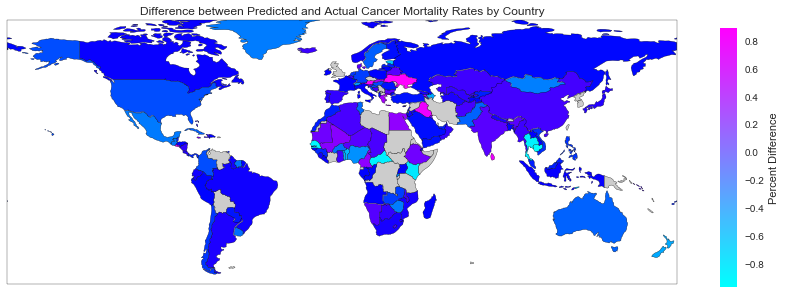

In [591]:
# plot cartopy world map projection
# ax = plt.axes(projection=ccrs.PlateCarree())
fig, ax = plt.subplots(figsize=(12,6), 
                       subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-150, 60, -25, 60])

# initialize the type of projdction and map outline format
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

# initialize counter variable k 
k = 0
for country in countries:
    
    # for each country with a country code, color the country in proportion to the cardiovascular mortality rate
    if any(country.attributes['adm0_a3'] in j for (k,j) in enumerate(codes)):
        if float_cancer_array[k] > 0:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor=[abs((float_cancer_array[k])/max_value), 0, 1],
                          label=country.attributes['adm0_a3'])
        else:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                      facecolor=[0, abs((float_cancer_array[k])/abs(min_value)), 1],
                      label=country.attributes['adm0_a3'])
        k = k + 1
    
    # color Greenland to match Iceland
    elif country.attributes['adm0_a3'] == 'GRL':
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor=[0, abs((float_cancer_array[k])/abs(max_value)), 1],
                          label=country.attributes['adm0_a3'])
    
    # for all countries with no cardiovascular mortality data, leave the country blank
    else:
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor = [0.8, 0.8, 0.8],
                          label=country.attributes['adm0_a3'])
    ax.set_title('Difference between Predicted and Actual Cancer Mortality Rates by Country')
    
    cmap = plt.cm.cool
    cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
    norm = mpl.colors.Normalize(vmin=min_value, vmax=max_value)
    cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional')
    cb.set_label('Percent Difference')

plt.show()

Here we again find the maximum and minimum to determine the color gradient. 

In [592]:
diabetes_rates = diff_matrix[:,2]
float_diabetes_array = []
for each in diabetes_rates:
    float_diabetes_array.append(float(each))
max_value = np.max(float_diabetes_array) 
min_value = np.min(float_diabetes_array) 

## Analysis for Diabetes Error Map

Below we generate the world map for diabetes using the correct shading for each country and gray if we don't have data for the country. Again, dark blue and dark purple represent small fractional errors, while bright pink and bright teal represent predictions that are more off. Most countries are dark blue or dark purple. We notice that the United States and Russia is not dark blue or dark purple, but a lighter blue, meaning that the true value is smaller than the predicted value, so we overestimated the mortality rate. We conjecture that this is because the United States and Russia are generally very developed countries that have superior medical care. As a result, the true mortality rate will be smaller than expected. 

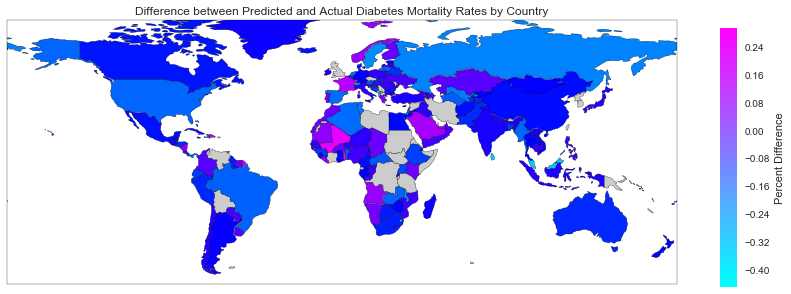

In [595]:
# plot cartopy world map projection
# ax = plt.axes(projection=ccrs.PlateCarree())
fig, ax = plt.subplots(figsize=(12,6), 
                       subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-150, 60, -25, 60])

# initialize the type of projdction and map outline format
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

# initialize counter variable k 
k = 0
for country in countries:
    
    # for each country with a country code, color the country in proportion to the cardiovascular mortality rate
    if any(country.attributes['adm0_a3'] in j for (k,j) in enumerate(codes)):
        if float_diabetes_array[k] > 0:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor=[abs((float_diabetes_array[k])/max_value), 0, 1],
                          label=country.attributes['adm0_a3'])
        else:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                      facecolor=[0, abs((float_diabetes_array[k])/abs(min_value)), 1],
                      label=country.attributes['adm0_a3'])
        k = k + 1
    
    # color Greenland to match Iceland
    elif country.attributes['adm0_a3'] == 'GRL':
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                      facecolor=[abs(float(float_diabetes_array[k])/max_value), 0, 1],
                      label=country.attributes['adm0_a3'])
    
    # for all countries with no cardiovascular mortality data, leave the country blank
    else:
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor = [0.8, 0.8, 0.8],
                          label=country.attributes['adm0_a3'])
    ax.set_title('Difference between Predicted and Actual Diabetes Mortality Rates by Country')
    
    cmap = plt.cm.cool
    cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
    norm = mpl.colors.Normalize(vmin=min_value, vmax=max_value)
    cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional')
    cb.set_label('Percent Difference')

plt.show()

Repeating one last time for cardiovascular disease.

In [596]:
cardio_rates = diff_matrix[:,3]
float_cardio_array = []
for each in cardio_rates:
    float_cardio_array.append(float(each))
max_value = np.max(float_cardio_array) 
min_value = np.min(float_cardio_array) 

## Analysis for Cardiovascular Error Map

The cardiovasular error map is mostly fairly accurate (darker colors shown on map), but for certain countries in Eastern Europe and Central Asia show a relatively larger fractional difference. This might be because the 

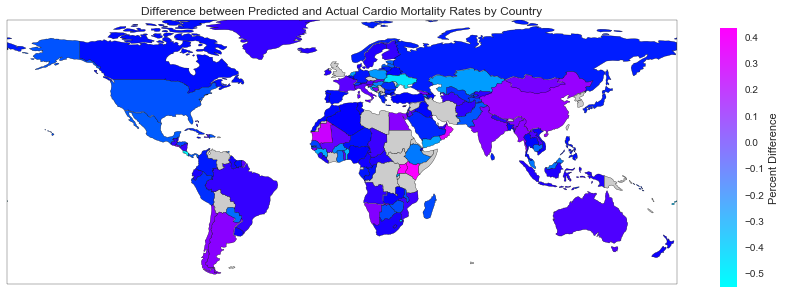

In [598]:
# plot cartopy world map projection
# ax = plt.axes(projection=ccrs.PlateCarree())
fig, ax = plt.subplots(figsize=(12,6), 
                       subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-150, 60, -25, 60])

# initialize the type of projdction and map outline format
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

# initialize counter variable k 
k = 0
for country in countries:
    
    # for each country with a country code, color the country in proportion to the cardiovascular mortality rate
    if any(country.attributes['adm0_a3'] in j for (k,j) in enumerate(codes)):
        if float_cardio_array[k] > 0:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor=[abs((float_cardio_array[k])/max_value), 0, 1],
                          label=country.attributes['adm0_a3'])
        else:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                      facecolor=[0, abs((float_cardio_array[k])/abs(min_value)), 1],
                      label=country.attributes['adm0_a3'])
        k = k + 1
    
    # color Greenland to match Iceland
    elif country.attributes['adm0_a3'] == 'GRL':
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor=[abs(float(float_cardio_array[k])/max_value), 0, 1],
                          label=country.attributes['adm0_a3'])
    
    # for all countries with no cardiovascular mortality data, leave the country blank
    else:
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor = [0.8, 0.8, 0.8],
                          label=country.attributes['adm0_a3'])
    ax.set_title('Difference between Predicted and Actual Cardio Mortality Rates by Country')
    
    cmap = plt.cm.cool
    cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
    norm = mpl.colors.Normalize(vmin=min_value, vmax=max_value)
    cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional')
    cb.set_label('Percent Difference')

plt.show()

---